# In order to start on this project, please download the data set from
*Cough Vid Data Source:*
https://zenodo.org/record/4048312#.YDjKw-oo9H5

*Virufy Covid Data Source:*
https://github.com/virufy/virufy-covid

*Coswara Data Set:*
https://github.com/iiscleap/Coswara-Data

**Setting Healthy as 0 and Covid positive as 1**

#Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
from functools import reduce
from collections import Counter
from keras.layers import *
import numpy as np
import itertools
import pandas
from sklearn.ensemble import VotingClassifier
import pickle
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as ipd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import CuDNNLSTM
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam # - Works
from keras.layers import Attention
from keras.layers import Activation
from keras.layers import ELU
from keras.layers import TimeDistributed 
from keras import regularizers
from keras import initializers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import tensorflow as tf
import cv2
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import keras.backend as K
from collections import Counter
from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy


Mounted at /content/drive


In [2]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)
    # top 5 accuracy for resnet 50
def getPred(p):
  # converting prediction into a single column
  pp = []
  p = p.tolist()
  for a in p:
    pp.append(a[0])
  return pp
def getMajorityVoting(A, B, C):
  # getting majority voting from all 6 models
  majority_voting = []
  for a, b, c  in zip(A, B, C):
    y = [a, b, c]
    x = Counter(y)
    print(x.most_common(1)[0][0])
    majority_voting.append(x.most_common(1)[0][0])
  return majority_voting

def getConfMatrix(A, B):
  # printing confusion matrix
  mat = confusion_matrix(A, B)
  labels = ['Negative', 'Positive']
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
              xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

def LoadAllTrainedModels():
  # loading all trained models
  
  model3mfcc =  tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/sequential3-98ACC-500outlier.h5')
  model4mfcc = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/model_mfcc_96.h5')
  resnet50mfcc = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/resnet50_Mfcc/my_model', custom_objects={'top_5_accuracy':top_5_accuracy})
  # model3delta = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Delta Mfcc/model3DeltaMFCC.h5')
  # model4delta = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Delta Mfcc/model_Deltamfcc_88.h5')
  # resnet50delta = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Delta Mfcc/resnet50_deltaMfcc', custom_objects={'top_5_accuracy':top_5_accuracy})
  return model3mfcc, model4mfcc, resnet50mfcc
  # return model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta

In [3]:
# model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta = LoadAllTrainedModels()

#Read Covid Samples ( Local Hospitals )

In [ ]:
def getMFCCDelta1(padding_length = 512, outliers = 500, reshape_length = 20):
# delta mfcc for local testing
# only return 5 healthy cases
  def getDeltaLables():
    all_labels = {}
    labeld = open("/content/drive/My Drive/FYP/metadata_compiled.csv", 'r').readlines()
    for alpha in labeld:
      alpha = alpha.split(",")
      all_labels[alpha[0]] = alpha[10]
    return all_labels


  def Convert_features_to_Floating_points(mfcc):
    result = []
    data = mfcc.split(":")
    for fp in data:
      result.append(float(fp))
    return result


  def Convert_features(mfccs):
    result = []
    data = mfccs.split("_")
    for d in data:
      result.append(Convert_features_to_Floating_points(d))
    return result

  def get_mfccs_delta():
    all_labels = getDeltaLables()
    file = open("/content/drive/My Drive/FYP/delta_mfccs.txt", 'r').readlines()
    MFCC_deltas = file[0].split("==")    
    files = []
    final_deltas = []
    labels = []
    i = 0
    for obj in MFCC_deltas:
      if i == 5:
        break
      try:
        objext = obj.split("|")
        objext[1]
      except:
        continue
      if "(1).wav" in objext[1]:
        continue
      ab = all_labels[objext[1][:-4]]
      if ab != "" and "symptomatic" not in ab:
        if ab == 'healthy':
          final_deltas.append(Convert_features(objext[0]))
          files.append(objext[1])
          i += 1
    return final_deltas, labels, files


  def pad(X, padding_length):
    while len(X) != padding_length:
      X.append(0.0)
    return np.array(X)
  def do_padding(mfcc, padding_length):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(pad(mf, padding_length))
    return np.array(new_mfcc)

# return flattened np arrays 
  def getFlattened(X):
    new_mfcc = []
    for mfcc in X:
      new_mfcc.append(np.array(mfcc).flatten().tolist())
    return new_mfcc
  

# delete outliers, 
# first we sort the values and then the first N number of outliers and the last N 
# number of outliers are deleted
  def deleteOutliers(newX, input_files ,X, y, outliers, reshape_length):
    alpha = sorted(newX, key = len)
    for i in range(0, outliers):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    for i in range(len(alpha)-outliers - 1 ,len(alpha)-1):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    return X, y

  def applyPad(X, padding_length):
    newX = []
    for mfcc in X:
      newX.append(do_padding(mfcc, padding_length).flatten())
    return newX
  def get_segmented(X):
    newX = []
    for mfcc in X:
      newX.append(mfcc)
    return newX

  X, y, input_files = get_mfccs_delta()
  print(len(X))
  newX = getFlattened(X)
  # X, y = deleteOutliers(newX,input_files, X, y, outliers, reshape_length)
  X = get_segmented(X)
  X = applyPad(X, padding_length)
  del newX
  return X, y


In [ ]:
def getMFCCs5(padding_length = 512, outliers = 500, reshape_length = 20):

# convert a string of mfccs into floating points
  def convertFloat(features):
    feat = []
    f = features.split(",")
    for fe in f:
      feat.append(float(fe))
    return feat

# split the string on the basis of delimeter
  def Read_Split(mfccs):
    features = mfccs.split('=')
    feat = []
    for feature in features:
      feat.append(convertFloat(feature))
    return feat

# reading and splittting the mfccs
  def readMFCCS():
    file = open("/content/drive/My Drive/FYP/MFCCs.txt", 'r').readlines()
    mfccs = []
    labels = []
    input_files = []
    i = 0
    for lines in file:
      if i == 5:
        break
      param = lines.split("|")
      input_files.append(param[0])
      features = param[1]
      lable = param[2][:-1]
      if 'healthy' in lable:
        mfccs.append(Read_Split(features))
        i += 1
      
      del lable
      del param
    return mfccs, labels, input_files
# padding the mfccs to the padding_length that is initially set to 512
  def pad(X, padding_length):
    while len(X) != padding_length:
      X.append(0.0)
    return np.array(X)
  def do_padding(mfcc, padding_length):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(pad(mf, padding_length))
    return np.array(new_mfcc)

# return flattened np arrays 
  def getFlattened(X):
    new_mfcc = []
    for mfcc in X:
      new_mfcc.append(np.array(mfcc).flatten().tolist())
    return new_mfcc
  

# delete outliers, 
# first we sort the values and then the first N number of outliers and the last N 
# number of outliers are deleted
  def deleteOutliers(newX, input_files ,X, y, outliers, reshape_length):
    alpha = sorted(newX, key = len)
    for i in range(0, outliers):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    for i in range(len(alpha)-outliers - 1 ,len(alpha)-1):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    return X, y

  def applyPad(X, padding_length):
    newX = []
    for mfcc in X:
      newX.append(do_padding(mfcc, padding_length).flatten())
    return newX
  def get_segmented(X):
    newX = []
    for mfcc in X:
      newX.append(mfcc)
    return newX

  X, y, input_files = readMFCCS()
  newX = getFlattened(X)
  # X, y = deleteOutliers(newX,input_files, X, y, outliers, reshape_length)
  X = get_segmented(X)
  X = applyPad(X, padding_length)
  del newX
  return X, y

In [ ]:
def Append(mfcc):
    if len(mfcc)>512:
      return mfcc
    while len(mfcc) != 512:
      mfcc.append(0.0)
    return mfcc
def make_append(mfcc):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(Append(mf.tolist()))
    return new_mfcc
# converting a string of mfcc into a np araay

In [ ]:
def RUNCovidSamples():
  def Append(mfcc):
    if len(mfcc)>512:
      return mfcc
    while len(mfcc) != 512:
      mfcc.append(0.0)
    return mfcc
  def make_append(mfcc):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(Append(mf.tolist()))
    return new_mfcc

# __-------------------local hospital 5 covid positve cases ---------------------
  X_mfcc = []
  X_delta = []
  new_y = [ 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
  samples = ['1', '2', '3', '4', '5']
  healthy_sam = []
  for i in samples:
    y, sr = librosa.load('/content/drive/My Drive/FYP/Covid Samples/' + i + '.wav')
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    X_mfcc.append(make_append(mfcc))
    X_delta.append(make_append(mfcc_delta))

  X_delta = np.asarray(X_delta).reshape(-1,160, 16, 4 )
  X_mfcc = np.asarray(X_mfcc).reshape(-1,160, 16, 4 )
  X_mfcc = preprocessing.scale(preprocessing.normalize(X_mfcc.reshape(-1, 1)))
  X_delta = preprocessing.scale(preprocessing.normalize(X_delta.reshape(-1, 1)))

  localmodel3mfcc_pred = getPred(model3mfcc.predict(X_mfcc.reshape(-1, 160, 16, 4))>0.5)
  localmodel4mfcc_pred = getPred(model4mfcc.predict(X_mfcc.reshape(-1, 160, 16, 4))>0.5)
  localmodel3delta_pred = getPred(model3delta.predict(X_delta.reshape(-1, 160, 16, 4))>0.5)
  localmodel4delta_pred = getPred(model4delta.predict(X_delta.reshape(-1, 160, 16, 4))>0.5)
  localresnet50mfcc_pred = getPred(resnet50mfcc.predict(X_mfcc.reshape(-1, 160, 16, 4))>0.5)
  localresnet50delta_pred = getPred(resnet50delta.predict(X_delta.reshape(-1, 160, 16, 4))>0.5)
  # ------------------------------------------------------------------------------

  # -------------------- Healthy Sources from CoughVid -------------------------
  X_delta_coughvid, y = getMFCCDelta1()
  X_mfcc_coughvid, y = getMFCCs5()
  X_delta_coughvid = np.asarray(X_delta_coughvid)
  X_mfcc_coughvid = np.asarray(X_mfcc_coughvid)
  X_mfcc_coughvid = preprocessing.scale(preprocessing.normalize(X_mfcc_coughvid.reshape(-1, 1)))
  X_delta_coughvid = preprocessing.scale(preprocessing.normalize(X_delta_coughvid.reshape(-1, 1)))

  coughvidmodel3mfcc_pred = getPred(model3mfcc.predict(X_mfcc_coughvid.reshape(-1, 160, 16, 4))>0.5)
  coughvidmodel4mfcc_pred = getPred(model4mfcc.predict(X_mfcc_coughvid.reshape(-1, 160, 16, 4))>0.5)
  coughvidmodel3delta_pred = getPred(model3delta.predict(X_delta_coughvid.reshape(-1, 160, 16, 4))>0.5)
  coughvidmodel4delta_pred = getPred(model4delta.predict(X_delta_coughvid.reshape(-1, 160, 16, 4))>0.5)
  coughvidresnet50mfcc_pred = getPred(resnet50mfcc.predict(X_mfcc_coughvid.reshape(-1, 160, 16, 4))>0.5)
  coughvidresnet50delta_pred = getPred(resnet50delta.predict(X_delta_coughvid.reshape(-1, 160, 16, 4))>0.5)
  # ---------------------------------------------------------------------

  def getMajorityVoting(A, B, C):
    majority_voting = []
    for a, b, c  in zip(A, B, C):
      y = [a, b, c]
      x = Counter(y)
      majority_voting.append(x.most_common(1)[0][0])
    return majority_voting
  
  
  

  final_prediction = []
  for pre in localmodel4mfcc_pred:
    final_prediction.append(pre)
  for pre in coughvidmodel4delta_pred:
    final_prediction.append(pre)
  printEval(new_y,final_prediction )
  getConfMatrix(final_prediction, new_y)


In [ ]:
# RUNCovidSamples()

#Reading Coswara Data

In [ ]:
def convertt(mfcc):
  to_return = []
  mfcc = mfcc.split(":")
  for data in mfcc:
    to_return.append(float(data))
  return to_return    
def convert_to_f(mfccs):
  to_return = []
  for mfcc in mfccs[:-1]:
    to_return.append(convertt(mfcc))
  return to_return, mfccs[-1]
def getCoswaraData(path):
  file = open("/content/drive/My Drive/FYP/Coswara/" + path + ".txt", 'r')
  X = []
  y = []
  for lines in file:
    whole_mfcc = lines.split("||")
    for mfccs in whole_mfcc:
      Xx, Yy = convert_to_f(mfccs.split("|"))
      X.append(Xx)
      if Yy == "healthy":
        y.append(0)
      else:
        y.append(1)
      del Xx, Yy
  X = X[:-1]
  X = np.asarray(X)
  return X, y

In [ ]:
def do__():
  X_mfccs , y_mfccs = getCoswaraData("Omer/mfcc_coswara")
  X_mfccs_old , y_mfccs_old = getCoswaraData("Faaira/mfcc_coswara")
  final_X = []
  final_Y = []
  for data, yy in zip(X_mfccs, y_mfccs):
    final_X.append(data)
    final_Y.append(yy)
  for data, yy in zip(X_mfccs_old, y_mfccs_old):
    final_X.append(data)
    final_Y.append(yy)
  return np.asarray(final_X).reshape(-1, 20, 128, 4), final_Y

In [ ]:
def RunCoswaraSamples(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta):
  X_mfccs , y_mfccs = getCoswaraData("mfcc_coswara")
  X_delta , y_delta = getCoswaraData("delta_mfcc_coswara")
  X_mfccs_old , y_mfccs_old = getCoswaraData("mfcc_coswara")
  X_delta_old , y_delta_old = getCoswaraData("delta_mfcc_coswara")
  #getting coswara data 
  # model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta = LoadAllTrainedModels()
  model3mfcc_predo = getPred(model3mfcc.predict(X_mfccs_old.reshape(-1,160, 16, 4 )))
  model4mfcc_predo = getPred(model4mfcc.predict(X_mfccs_old.reshape(-1,160, 16, 4 )))
  model3delta_predo = getPred(model3delta.predict(X_delta_old.reshape(-1, 160, 16, 4)))
  model4delta_predo = getPred(model4delta.predict(X_delta_old.reshape(-1, 160, 16, 4)))
  resnet50mfcc_predo = getPred(resnet50mfcc.predict(X_mfccs_old.reshape(-1,160, 16, 4 )))
  resnet50delta_predo = getPred(resnet50delta.predict(X_delta_old.reshape(-1,160, 16, 4 )))
  model3mfcc_pred = getPred(model3mfcc.predict(X_mfccs.reshape(-1,160, 16, 4 )))
  model4mfcc_pred = getPred(model4mfcc.predict(X_mfccs.reshape(-1,160, 16, 4 )))
  model3delta_pred = getPred(model3delta.predict(X_delta.reshape(-1, 160, 16, 4)))
  model4delta_pred = getPred(model4delta.predict(X_delta.reshape(-1, 160, 16, 4)))
  resnet50mfcc_pred = getPred(resnet50mfcc.predict(X_mfccs.reshape(-1,160, 16, 4 )))
  resnet50delta_pred = getPred(resnet50delta.predict(X_delta.reshape(-1,160, 16, 4 )))
  #applying prediction
  majority_voting_new = getMajorityVoting(model3mfcc_pred, model4mfcc_pred,model3delta_pred
                                          , model4delta_pred ,resnet50mfcc_pred, resnet50delta_pred)
  majority_voting_old = getMajorityVoting(model3mfcc_predo, model4mfcc_predo,model3delta_predo
                                          , model4delta_predo ,resnet50mfcc_predo, resnet50delta_predo)
  #applying majority voting on models
  all_maj = []
  for data in majority_voting_new:
    all_maj.append(data)
  for data in majority_voting_old:
    all_maj.append(data)
  
  all_y = []
  for data in y_mfccs_old[:-1]:
    all_y.append(data)
  for data in y_mfccs[:-1]:
    all_y.append(data)
  
  printEval(all_maj, all_y)
  getConf(all_maj, all_y)

In [ ]:
# RunCoswaraSamples(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)

#Reading Virufy Covid Data

In [ ]:
def getVirufyCovid(): 
  def Append(mfcc):
    if len(mfcc)>512:
      print("Jani bad scene")
      return mfcc
    while len(mfcc) != 512:
      mfcc.append(0.0)
    return mfcc
  def make_append(mfcc):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(Append(mf.tolist()))
    return new_mfcc  
  def makeDictionary():
    d = dict()
    file = open("/content/drive/My Drive/FYP/Virufy-Covid/labled.txt", 'r')
    for lines in file:
      d[lines.split(',')[0]] = lines.split(',')[1][:-1]
    d['ARSH'] = 'positive'
    return d

  cough_files = os.listdir('/content/drive/My Drive/FYP/Virufy-Covid/dataset/')
  y = makeDictionary()
  newY = []
  no_files = []
  for files in cough_files:
    try:
      if y[files.split(".")[0]]== 'negative':
        no_files.append(files)
        continue
      else:
        newY.append(1)
    except:
      print(files)
  X_mfcc = []
  # X_delta = []
  for files in cough_files:
    if files not in no_files:
      y, sr = librosa.load("/content/drive/My Drive/FYP/Virufy-Covid/dataset/" + files)
      mfcc = librosa.feature.mfcc(y=y, sr=sr)
      # mfcc_delta = librosa.feature.delta(mfcc)
      X_mfcc.append(make_append(mfcc))
      # X_delta.append(make_append(mfcc_delta))
  return np.asarray(X_mfcc), newY
  # return np.asarray(X_mfcc), np.asarray(X_delta), newY

In [ ]:
def getPredictionForAll(X_mfcc, X_delta, model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta):
  # model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta = LoadAllTrainedModels()
  #getting model predictions
  model3mfcc_pred = getPred(model3mfcc.predict(X_mfcc.reshape(-1,160, 16, 4 )))
  model4mfcc_pred = getPred(model4mfcc.predict(X_mfcc.reshape(-1,160, 16, 4 )))
  model3delta_pred = getPred(model3delta.predict(X_delta.reshape(-1, 160, 16, 4)))
  model4delta_pred = getPred(model4delta.predict(X_delta.reshape(-1, 160, 16, 4)))
  resnet50mfcc_pred = getPred(resnet50mfcc.predict(X_mfcc.reshape(-1,160, 16, 4 )))
  resnet50delta_pred = getPred(resnet50delta.predict(X_delta.reshape(-1,160, 16, 4 )))
  #applying majority voting
  majority_voting_new = getMajorityVoting(model3mfcc_pred, model4mfcc_pred,
                                          model3delta_pred, model4delta_pred ,resnet50mfcc_pred, resnet50delta_pred)
  return majority_voting_new 
def getPred(p):
  # converting prediction into a single column
  pp = []
  p = p.tolist()
  for a in p:
    if a[0] == False:
      pp.append(1)
    else:
      pp.append(0)
  return pp

In [ ]:
#getting predcitions and displaying results
def RunVirifyCovid(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta):
  X_mfcc, X_delta, y = getVirufyCovid()
  y_prediction = getPredictionForAll(X_mfcc, X_delta, model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)
  printEval(y_prediction, y)
  getConfMatrix(y_prediction, y)


In [ ]:
# RunVirifyCovid(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)

In [ ]:
#reading both virufy and coswara dataset to get predictions
def readBothVirufyCoswara( model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta):
  #loading data
  X_mfccs , y_mfccs = getData("mfcc_coswara")
  X_delta , y_delta = getData("delta_mfcc_coswara")
  X_mfccs_old , y_mfccs_old = getData("mfcc_coswara")
  X_delta_old , y_delta_old = getData("delta_mfcc_coswara")
  # model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta = LoadAllTrainedModels()
  #getting predictions
  model3mfcc_predo = getPred(model3mfcc.predict(X_mfccs_old.reshape(-1,160, 16, 4 )))
  model4mfcc_predo = getPred(model4mfcc.predict(X_mfccs_old.reshape(-1,160, 16, 4 )))
  model3delta_predo = getPred(model3delta.predict(X_delta_old.reshape(-1, 160, 16, 4)))
  model4delta_predo = getPred(model4delta.predict(X_delta_old.reshape(-1, 160, 16, 4)))
  resnet50mfcc_predo = getPred(resnet50mfcc.predict(X_mfccs_old.reshape(-1,160, 16, 4 )))
  resnet50delta_predo = getPred(resnet50delta.predict(X_delta_old.reshape(-1,160, 16, 4 )))
  # the data was in the form of two seperate phases, each stored in a different folder
  model3mfcc_pred = getPred(model3mfcc.predict(X_mfccs.reshape(-1,160, 16, 4 )))
  model4mfcc_pred = getPred(model4mfcc.predict(X_mfccs.reshape(-1,160, 16, 4 )))
  model3delta_pred = getPred(model3delta.predict(X_delta.reshape(-1, 160, 16, 4)))
  model4delta_pred = getPred(model4delta.predict(X_delta.reshape(-1, 160, 16, 4)))
  resnet50mfcc_pred = getPred(resnet50mfcc.predict(X_mfccs.reshape(-1,160, 16, 4 )))
  resnet50delta_pred = getPred(resnet50delta.predict(X_delta.reshape(-1,160, 16, 4 )))
  #applying majority voting
  majority_voting_new = getMajorityVoting(model3mfcc_pred, model4mfcc_pred,model3delta_pred
                                          , model4delta_pred ,resnet50mfcc_pred, resnet50delta_pred)
  majority_voting_old = getMajorityVoting(model3mfcc_predo, model4mfcc_predo,model3delta_predo
                                          , model4delta_predo ,resnet50mfcc_predo, resnet50delta_predo)
  all_maj = []
  for data in majority_voting_new:
    all_maj.append(data)
  for data in majority_voting_old:
    all_maj.append(data)
  
  all_y = []
  for data in y_mfccs_old[:-1]:
    all_y.append(data)
  for data in y_mfccs[:-1]:
    all_y.append(data)

  X_mfccvirufy, X_deltavirufy, yvirufy = getVirufyCovid()
  yvirufy = (np.array(yvirufy) == 0).tolist()
  y_prediction = getPredictionForAll(X_mfccvirufy, X_deltavirufy, model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)
  y_prediction = (np.array(y_prediction) == 0).tolist()
  for data in y_prediction:
    all_maj.append(data)
  for data in yvirufy:
    all_y.append(data)
  printEval(all_maj, all_y)
  getConfMatrix(all_maj, all_y)

In [ ]:
# readBothVirufyCoswara(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)

#**Reading Data**

##***Apply Random Sampler first, and then SMOTE***

In [4]:
def OverSampling(X, Y):
  from imblearn.pipeline import Pipeline
  smote = SMOTE()
  randomSampler = RandomOverSampler()
  #first put random over sampler and then the smote technique
  pipeline = Pipeline([ ('randomSampler', randomSampler), ('smote', smote)])
  return pipeline.fit_resample(X, Y)

In [5]:
def OverSamplingSmoteENN(X, Y):
  from imblearn.combine import SMOTEENN
  smenn = SMOTEENN()
  X_train, y_train = smenn.fit_resample(X, Y)
  return X_train, y_train

In [6]:
def OverSamplingSmoteTomek(X, Y):
  from imblearn.combine import SMOTETomek
  smenn = SMOTETomek(random_state = 139)
  X_train, y_train = smenn.fit_resample(X, Y)
  return X_train, y_train

In [7]:
def OverSamplingSmoteADASYN(X, Y):
  from imblearn.over_sampling import ADASYN
  smenn = ADASYN(random_state = 139)
  X_train, y_train = smenn.fit_resample(X, Y)
  return X_train, y_train

##Getting Delta Mfccs From Cough-Vid Data Source

In [8]:
def getMFCCDelta(padding_length = 512, outliers = 500, reshape_length = 20):
  # getting delta labels
  def getDeltaLables():
    all_labels = {}
    labeld = open("/content/drive/My Drive/FYP/metadata_compiled.csv", 'r').readlines()
    for alpha in labeld:
      alpha = alpha.split(",")
      all_labels[alpha[0]] = alpha[10]
    return all_labels

  # converting features to floating points
  def Convert_features_to_Floating_points(mfcc):
    result = []
    data = mfcc.split(":")
    for fp in data:
      result.append(float(fp))
    return result
  def Convert_features(mfccs):
    result = []
    data = mfccs.split("_")
    for d in data:
      result.append(Convert_features_to_Floating_points(d))
    return result
# getting data from mfcc
  def get_mfccs_delta():
    all_labels = getDeltaLables()
    file = open("/content/drive/My Drive/FYP/delta_mfccs.txt", 'r').readlines()
    MFCC_deltas = file[0].split("==")    
    files = []
    final_deltas = []
    labels = []
    for obj in MFCC_deltas:
      try:
        objext = obj.split("|")
        objext[1]
      except:
        continue
      if "(1).wav" in objext[1]:
        continue
      ab = all_labels[objext[1][:-4]]
      if ab != "" and "symptomatic" not in ab:
        final_deltas.append(Convert_features(objext[0]))
        files.append(objext[1])
        if ab == 'healthy':
          labels.append(0)
        else:
          labels.append(1)
    return final_deltas, labels, files

# apply padding
  def pad(X, padding_length):
    while len(X) != padding_length:
      X.append(0.0)
    return np.array(X)
  def do_padding(mfcc, padding_length):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(pad(mf, padding_length))
    return np.array(new_mfcc)

# return flattened np arrays 
  def getFlattened(X):
    new_mfcc = []
    for mfcc in X:
      new_mfcc.append(np.array(mfcc).flatten().tolist())
    return new_mfcc
  

# delete outliers, 
# first we sort the values and then the first N number of outliers and the last N 
# number of outliers are deleted
  def deleteOutliers(newX, input_files ,X, y, outliers, reshape_length):
    alpha = sorted(newX, key = len)
    for i in range(0, outliers):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    for i in range(len(alpha)-outliers - 1 ,len(alpha)-1):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    return X, y
# apply padding on the entire mfcc
  def applyPad(X, padding_length):
    newX = []
    for mfcc in X:
      newX.append(do_padding(mfcc, padding_length).flatten())
    return newX
  def get_segmented(X):
    newX = []
    for mfcc in X:
      newX.append(mfcc)
    return newX

  X, y, input_files = get_mfccs_delta()
  newX = getFlattened(X)
  X, y = deleteOutliers(newX,input_files, X, y, outliers, reshape_length)
  X = get_segmented(X)
  X = applyPad(X, padding_length)
  del newX
  return X, y
def perform(Data):
  X = Data[0]
  y = Data[1]
  x_shape = 160
  y_shape = 16 
  z_shape = 4
  final_y = []
  # preprocess
  X = preprocessing.scale(preprocessing.normalize(X))
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=1)
  # oversampling
  X_train, y_train  = OverSampling(X_train, y_train)
  y_train = np.asarray(y_train)
  y_val = np.asarray(y_val)
  y_test = np.asarray(y_test)
  X_train = np.reshape(X_train, (X_train.shape[0], x_shape, y_shape, z_shape))
  X_val = np.reshape(X_val, (X_val.shape[0], x_shape, y_shape, z_shape))
  X_test = np.reshape(X_test, (X_test.shape[0], x_shape, y_shape, z_shape))
  return X_train, X_val, y_train, y_val, X_test, y_test


12516 total number of cough vid data entries


In [9]:
# X_train, X_val, y_train, y_val, X_test, y_test = perform(getMFCCDelta())

##Getting Mfccs from CoughVid Data Source

In [10]:
def getMFCCs(padding_length = 512, outliers = 500, reshape_length = 20):

# convert a string of mfccs into floating points
  def convertFloat(features):
    feat = []
    f = features.split(",")
    for fe in f:
      feat.append(float(fe))
    return feat

# split the string on the basis of delimeter
  def Read_Split(mfccs):
    features = mfccs.split('=')
    feat = []
    for feature in features:
      feat.append(convertFloat(feature))
    return feat

# reading and splittting the mfccs
  def readMFCCS():
    file = open("/content/drive/My Drive/FYP/MFCCs.txt", 'r').readlines()
    mfccs = []
    labels = []
    input_files = []
    for lines in file:
      param = lines.split("|")
      input_files.append(param[0])
      features = param[1]
      lable = param[2][:-1]
      mfccs.append(Read_Split(features))
      if 'healthy' in lable:
        labels.append(0)
      else:
        labels.append(1)
      del lable
      del param
    return mfccs, labels, input_files
# padding the mfccs to the padding_length that is initially set to 512
  def pad(X, padding_length):
    while len(X) != padding_length:
      X.append(0.0)
    return np.array(X)
  def do_padding(mfcc, padding_length):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(pad(mf, padding_length))
    return np.array(new_mfcc)

# return flattened np arrays 
  def getFlattened(X):
    new_mfcc = []
    for mfcc in X:
      new_mfcc.append(np.array(mfcc).flatten().tolist())
    return new_mfcc
  

# delete outliers, 
# first we sort the values and then the first N number of outliers and the last N 
# number of outliers are deleted
  def deleteOutliers(newX, input_files ,X, y, outliers, reshape_length):
    alpha = sorted(newX, key = len)
    for i in range(0, outliers):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    for i in range(len(alpha)-outliers - 1 ,len(alpha)-1):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    return X, y

  def applyPad(X, padding_length):
    newX = []
    for mfcc in X:
      newX.append(do_padding(mfcc, padding_length).flatten())
    return newX
  def get_segmented(X):
    newX = []
    for mfcc in X:
      newX.append(mfcc)
    return newX

  X, y, input_files = readMFCCS()
  newX = getFlattened(X)
  X, y = deleteOutliers(newX,input_files, X, y, outliers, reshape_length)
  X = get_segmented(X)
  X = applyPad(X, padding_length)
  del newX
  return X, y, input_files

##Spectral Centroids

In [ ]:
#this is to get the spectral centroids
def getSpecs(path):
#convert a string to floating points
  def stringtofloat(s):
    s_l = s.split('|')
    string = s_l[0]
    label = s_l[1]
    del s_l
    floating_points = string.split('_')
    array = []
    for fp in floating_points:
      array.append(float(fp))
    return array, label
    #apply padding
  def pad(X):
    while len(X) != 512:
      X.append(0.0)
    return np.array(X)

  def doPad(X):
    newX = []
    for xx in X:
      newX.append(pad(xx))
    return np.array(newX)
    #reading features
  def readfeatures(path):
    sp = open(path, 'r')
    X = []
    y = []
    for lines in sp:
      array, label = stringtofloat(lines)
      X.append(array)
      if "healthy" in label:
        y.append(0)
      else:
        y.append(1)
      del array
      del label
    return X, y
  # Removing the bottom 100 and top 100 outliers. 
  # print(len(X), len(y))
  def deleteOutliers(X, y):
    alpha = sorted(X, key = len)
    for i in range(0, 100):
      index = X.index(alpha[i])
      del (X[index])
      del (y[index])
    for i in range(len(alpha)- 101, len(alpha)- 1):
      index = X.index(alpha[i])
      del (X[index])
      del (y[index])
    del alpha
    return X, y



  X, y = readfeatures(path)
  X, y = deleteOutliers(X, y)
  X = doPad(X)

  return X, y



##Calling Above

In [11]:
def getData(path, which):
  if which == "SC":
    x_shape = 8 
    y_shape = 16 
    z_shape = 4
    X, y = getSpecs(path)
  else:
    x_shape = 20
    y_shape = 128 
    z_shape = 4
    X, y, input_files = getMFCCs()
  X = preprocessing.scale(preprocessing.normalize(X))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=1)
  new_y = []
  for data in y_train:
    if data == 0:
      new_y.append(2)
    else:
      new_y.append(3)
  X_smote, y_smote  = OverSampling(X_train, new_y)
  y_smote = np.asarray(y_smote)
  y_train = np.asarray(y_train)
  y_val = np.asarray(y_val)
  y_test = np.asarray(y_test)
  X_train = np.reshape(X_train, (X_train.shape[0], x_shape, y_shape, z_shape))
  X_val = np.reshape(X_val, (X_val.shape[0], x_shape, y_shape, z_shape))
  X_test = np.reshape(X_test, (X_test.shape[0], x_shape, y_shape, z_shape))
  # return X_test[0].reshape(-1, 20, 128, 4)
  return X_train, X_val, y_train, y_val, X_test, y_test, X_smote, y_smote

In [ ]:
def getCoughvid():
  X, y, input_files = getMFCCs()
  X = preprocessing.scale(preprocessing.normalize(X))
  return X.reshape(-1, 20, 128, 4), y

In [12]:
X_train, X_val, y_train, y_val, X_test, y_test, X_smote, y_smote = getData(1, 1)

In [ ]:
X_smote = X_smote.reshape(-1, 10240)
X_train = X_train.reshape(-1, 10240)

In [ ]:
SmoteX, SmoteY = [], []
alpha = np.isin(X_train, X_smote)

In [ ]:
counter = 0
for data in alpha.tolist():
  if data == False:
    counter += 1
print(counter)

0


In [ ]:
import pandas as pd
dfTrain = pd.DataFrame(X_train)

In [ ]:
dfSmote = pd.DataFrame(X_smote)

In [ ]:
df = dfSmote.merge(dfTrain, how = 'inner' ,indicator=False)


In [ ]:
df2 = dfTrain.merge(dfSmote, how = 'inner' ,indicator=False)


In [ ]:
X_smote.shape[0]- X_train.shape[0]

5865

In [ ]:
asl = X_smote.tolist()
SmoteX = []
SmoteY = []
for i, data in enumerate(asl):
  try:
    print(alre[hash(tuple(data))], i)
  except:
    SmoteX.append(data)
    SmoteY.append(y_train[i])

Streaming output truncated to the last 5000 lines.
1 7902
1 7903
1 7904
1 7905
1 7906
1 7907
1 7908
1 7909
1 7910
1 7911
1 7912
1 7913
1 7914
1 7915
1 7916
1 7917
1 7918
1 7919
1 7920
1 7921
1 7922
1 7923
1 7924
1 7925
1 7926
1 7927
1 7928
1 7929
1 7930
1 7931
1 7932
1 7933
1 7934
1 7935
1 7936
1 7937
1 7938
1 7939
1 7940
1 7941
1 7942
1 7943
1 7944
1 7945
1 7946
1 7947
1 7948
1 7949
1 7950
1 7951
1 7952
1 7953
1 7954
1 7955
1 7956
1 7957
1 7958
1 7959
1 7960
1 7961
1 7962
1 7963
1 7964
1 7965
1 7966
1 7967
1 7968
1 7969
1 7970
1 7971
1 7972
1 7973
1 7974
1 7975
1 7976
1 7977
1 7978
1 7979
1 7980
1 7981
1 7982
1 7983
1 7984
1 7985
1 7986
1 7987
1 7988
1 7989
1 7990
1 7991
1 7992
1 7993
1 7994
1 7995
1 7996
1 7997
1 7998
1 7999
1 8000
1 8001
1 8002
1 8003
1 8004
1 8005
1 8006
1 8007
1 8008
1 8009
1 8010
1 8011
1 8012
1 8013
1 8014
1 8015
1 8016
1 8017
1 8018
1 8019
1 8020
1 8021
1 8022
1 8023
1 8024
1 8025
1 8026
1 8027
1 8028
1 8029
1 8030
1 8031
1 8032
1 8033
1 8034
1 8035
1 8036
1 80

In [ ]:
len(SmoteX)

0

In [ ]:
def Diff(li1, li2):
    return np.asarray(set(tuple(li1)) - set(tuple(li2))) + list(set(tuple(li2)) - set(tuple(li1)))

In [ ]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(X_smote.reshape(-1, 10240), columns = x)
fig = px.scatter_3d(df, x=1234, y=3400, z=8000, color = y_smote)
fig.show()

##working


In [ ]:
# del model , X_train, X_val, y_train, y_val, X_test, y_test

In [ ]:
model = getModel3((20, 128))

In [ ]:
# del model

In [ ]:
X_train, X_val, y_train, y_val, X_test, y_test = getData("/content/drive/My Drive/FYP/spectral_centroid.txt", 'mfcc')

In [ ]:
hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=5, verbose = 2, batch_size=1024)

In [ ]:
y_pred = model.predict(X_test)>0.5

In [ ]:
new_y = []
for i in y_pred:
  new_y.append(i[0] == False)

In [ ]:
# datapoint = getData("/content/drive/My Drive/FYP/spectral_centroid.txt", 'mfcc')

In [ ]:
del X_train, X_val, y_train, y_val, X_test, y_test

In [ ]:
def get():
  X_virufy, y_virufy = getVirufyCovid()
  X_virufy = X_virufy.reshape(-1, 20, 128, 4)


  X_coughvid, y_coughvid = getCoughvid()
  X_coughvid = X_coughvid.reshape(-1, 20, 128, 4)


  X_coswara, y_coswara = do__()


  X = np.concatenate([X_coughvid, X_coswara]).reshape(-1, 20, 128, 4)
  y = np.concatenate([y_coughvid, y_coswara])


  X = X.reshape(-1, 10240)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)



  X_train = np.concatenate([X_train, X_virufy.reshape(-1, 10240)])
  y_train = np.concatenate([y_train, y_virufy])
  X_train, y_train  = OverSampling(X_train, y_train)



  return X_train.reshape(-1, 20, 128, 4), X_val.reshape(-1, 20, 128, 4), y_train, y_val, X_test.reshape(-1, 20, 128, 4), y_test

In [ ]:
X_train, X_val, y_train, y_val, X_test, y_test = get()

In [ ]:
new_X_train = []
new_y_train = []
count = 0
for i , data in enumerate(y_train.tolist()):
  if data == 1:
    new_X_train.append(X_train.tolist()[i])
    new_y_train.append(data)
  else:
    if count < 1000:
      new_X_train.append(X_train.tolist()[i])
      new_y_train.append(data)


In [ ]:
new_X_train = np.asarray(new_X_train).reshape(-1, 20, 128, 4)
new_y_train = np.asarray(new_y_train)

In [ ]:
del model, X_train, X_val, y_train, y_val

In [ ]:
y_hgasd = y_train.tolist()

In [ ]:
type(y_hgasd)

list

In [ ]:
zero = 0
one = 0
for i in y_hgasd:
  if i == 0:
    zero += 1
  else:
    one += 1
print(zero, one)

In [ ]:
import plotly.express as px

In [82]:
def getPredictionsOriginal(y_pred):
  to_return = []
  for data in y_pred:
    to_return.append(data[1])
  return to_return
def getFinalY(y_pred, y_test):
  to_return = []
  for i, y in enumerate(y_pred):
    if y != y_test[i]:
      to_return.append('Wrong Predictions')
    elif y == True:
      to_return.append('Covid Positive')
    else:
      to_return.append("Negative")
  return to_return

In [84]:
model3mfcc =  tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/sequential3-98ACC-500outlier.h5')
y_pred = getPredictionsOriginal(model3mfcc.predict(X_test.reshape(-1, 160, 16, 4))>0.5)
printEval(y_pred, y_test)


Test Accuracy:  0.9828957836117741
Precision micro:  0.9828957836117741
F1 Score micro:  0.9828957836117741
Recall Micro:  0.9828957836117741
Recall Weighted:  0.9828957836117741


In [85]:
print(len(model3mfcc.layers))
model3mfcc.pop()
print(len(model3mfcc.layers))
lastLayer = model3mfcc.predict(X_test.reshape(-1, 160, 16, 4))
columns = []
for i in range(0, 64):
  columns.append(i)
y_pred = getFinalY(y_pred, y_test)

In [79]:
lastLayer.shape

(2514, 64)

##Kmeans Clustering

In [87]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(lastLayer, columns = x)
fig = px.scatter_3d(df, x=0, y=30, z=60, color = y_pred)
fig.show()

In [88]:
from sklearn.cluster import KMeans

In [90]:
kmeans = KMeans(2)
kmeans.fit(lastLayer)

KMeans(n_clusters=2)

In [93]:
# identified_clusters =  False

In [95]:
identified_clusters = kmeans.fit_predict(lastLayer)
identified_clusters

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

In [96]:
alpha = Counter(identified_clusters.tolist())
alpha

Counter({0: 2312, 1: 202})

In [ ]:
def getFinalY(y_pred, y_test):
  to_return = []
  for i, y in enumerate(y_pred):
    if y != y_test[i]:
      to_return.append('Wrong Predictions')
    elif y == True:
      to_return.append('Covid Positive')
    else:
      to_return.append("Negative")
  return to_return

In [103]:
y_pred = getFinalY(identified_clusters, y_test)

In [104]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(lastLayer, columns = x)
fig = px.scatter_3d(df, x=0, y=30, z=60, color = y_pred)
fig.show()

##Sentitivity and Specificity

TypeError: ignored

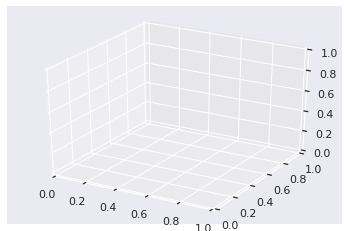

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X_test, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
# X_train, X_val, y_train, y_val, X_test, y_test = train_and_split_it(X, y)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("X_val Shape: ", X_val.shape)

X_train Shape:  (15694, 20, 128, 4)
X_test Shape:  (2661, 20, 128, 4)
X_val Shape:  (2129, 20, 128, 4)


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/all_data_mfcc_trained.h5')

In [ ]:
model.save('/content/drive/My Drive/FYP/Models/Mfcc/all_data_mfcc_trained.h5')

In [ ]:
hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=15, batch_size=1024)

Epoch 1/15
13/16 [=======================>......] - ETA: 5s - loss: 0.0035 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
y_pred = model.predict(X_test.reshape(-1, 160, 16, 4))<0.5

In [ ]:
new_y = []
for data in y_pred.tolist():
  new_y.append(data[0])

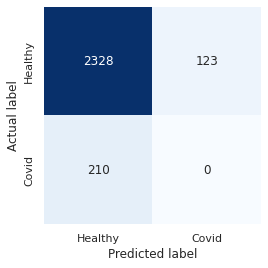

specificity(Negative Class):  0.91725768321513
sensitivity(Positive Class):  0.0
Precision:  0.0
Recall:  0.0
F-Score:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
Counter(y_test)

Counter({0: 2449, 1: 223})

In [ ]:
printEval(y_pred, y_test)

Test Accuracy:  0.8649862740204642
Precision micro:  0.8649862740204642
F1 Score micro:  0.8649862740204642
Recall Micro:  0.8649862740204642
Recall Weighted:  0.8649862740204642


In [ ]:
# path = '/content/drive/My Drive/FYP/FeatureImportance/'
# pickle.dump(datapoint, open(path + 'datapoint', 'wb'))

In [ ]:
# dp = pickle.load(open('/content/drive/My Drive/FYP/FeatureImportance/datapoint', 'rb'))

#Working Here

In [ ]:
# X_train = X_train.reshape(-1, 20, 128, 4)
# X_test = X_test.reshape(-1, 20, 128, 4)
# X_val = X_val.reshape(-1, 20, 128, 4)
del X_train, X_val, y_train, y_val

In [ ]:
# y, sr = librosa.load('/content/drive/My Drive/FYP/Covid Samples/1.wav')
# mfcc = librosa.feature.mfcc(y=y, sr=sr)
# mfcc = np.asarray(make_append(mfcc)).reshape(-1, 20, 128, 4)
# del y, sr


In [ ]:
model3mfcc, model4mfcc, resnet50mfcc = LoadAllTrainedModels()

In [ ]:
del model3mfcc, model4mfcc, resnet50mfcc

In [ ]:
X_mfccs , y_mfccs = getData("Omer/mfcc_coswara")
X_mfccs_old , y_mfccs_old = getData("Faaira/mfcc_coswara")

all_y = []
for data in y_mfccs_old[:-1]:
  all_y.append(data)
for data in y_mfccs[:-1]:
  all_y.append(data)

all_X = []
for data in X_mfccs:
  all_X.append(data)
for data in X_mfccs_old:
  all_X.append(data)
    

In [ ]:
all_X = all_X.tolist()

In [ ]:
for data in XV:
  all_X.append(data)

In [ ]:
for data in yy:
  all_y.append(data)

In [ ]:
# XV, y = getVirufyCovid()
XV = XV.reshape(-1, 160,16, 4)

In [ ]:
all_X = np.asarray(all_X).reshape(-1, 160,16, 4)

In [ ]:
# hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=5, batch_size=32)
y_pred = resnet50mfcc.predict(all_X)<0.5
y_ = model3mfcc.predict(all_X)<0.5
y__ = model4mfcc.predict(all_X)<0.5

In [ ]:
new_pred = []
for data in y_pred.tolist():
  new_pred.append(data[0])

In [ ]:
new_pred_ = []
for data in y_.tolist():
  new_pred_.append(data[0])

In [ ]:
new_pred__ = []
for data in y__.tolist():
  new_pred__.append(data[0])

In [ ]:
def getMajorityVoting(A, B, C):
  # getting majority voting from all 6 models
  majority_voting = []
  for a, b, c  in zip(A, B, C):
    y = [a, b, c]
    x = Counter(y)
    majority_voting.append(x.most_common(1)[0][0])
  return majority_voting

In [ ]:
yyy = getMajorityVoting(new_pred, new_pred_, new_pred__)

specificity(Negative Class):  0.9714673913043478
sensitivity(Positive Class):  0.038461538461538464
Precision:  0.08695652173913043
Recall:  0.038461538461538464
F-Score:  0.05333333333333333


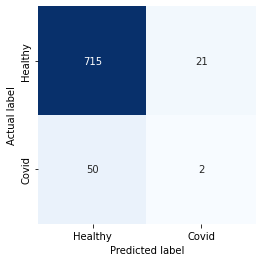

In [ ]:
# model =  tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/model3-20.h5')
# datapoint = getData("/content/drive/My Drive/FYP/spectral_centroid.txt", 'mfcc').copy()
# y_pred = model.predict(datapoint)

In [ ]:
def getallCombinations(data, subset):
  final_data = []
  for i, datapoints in enumerate(data[0]):
    if i in subset:
      final_data.append(np.random.rand(128, 4))
    else:
      final_data.append(datapoints)
  return np.asarray(final_data)
def getAllSubsets():
  numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
             11, 12, 13, 14, 15, 16, 17, 18, 19]
  all_subsets = []
  for L in range(0,  10):
      for subset in itertools.combinations(numbers, L):
          all_subsets.append(subset)
  return all_subsets
def getCombinations(data):
  final_data = []
  for subsets in all_subsets:
    final_data.append(getallCombinations(data, subsets))
  return final_data

In [ ]:
def featureImportance(model, datapoint, subset, y_predicted):
  new_datapoint = getallCombinations(datapoint, subset)
  new_pred = model.predict(np.asarray(new_datapoint).reshape(-1, 20, 128, 4))
  effect = ((y_predicted - new_pred) ** 2).mean() ** 0.5
  del new_datapoint, new_pred
  return ''.join(map(str, subset))  + " : " + str(effect) + '\n'
  

In [ ]:
model =  tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/model3-20.h5')
datapoint = getData("/content/drive/My Drive/FYP/spectral_centroid.txt", 'mfcc').copy()
y_pred = model.predict(datapoint)
file_ = open('/content/drive/My Drive/FYP/FeatureImportance/featureimportance.txt', 'a')
final_string = ''
percentage = 26
currently_done = 108315
all_subsets = getAllSubsets()[currently_done:]
for i, subset in enumerate(all_subsets):
  if (((i + currently_done) / 431910) * 100)  % 5 == float(percentage):
    print(((i + currently_done) / 431910) * 100)
    percentage += 1
  final_string += featureImportance(model, datapoint, subset, y_pred)

In [ ]:
all_subsets[77759]

(0, 3, 6, 7, 12, 15, 18)

In [ ]:
file_.write(final_string)
file_.close()

In [ ]:
def randomizeData(i, j, X_train):
  print(X_train.shape, i, j)
  new_array = []
  x = np.random.rand(512)
  for data in X_train:
    x_al = []
    for k , d in enumerate(data):
      if k == i or k == j:
        x_al.append(x)
      else:
        x_al.append(d)
    new_array.append(x_al)
    del x_al
  return np.asarray(new_array).reshape(-1, 20, 512)
    

In [ ]:
def compute_feature_importance(model, X_train, y_train, X_test, y_test, X_val, y_val):
  model.fit(X_train.reshape(-1, 20, 128, 4), y_train , validation_data=(X_val, y_val), epochs=5, batch_size=32)
  y_predicted = model.predict(X_test) > 0.5
  printEval(y_test, y_predicted)

In [ ]:
def feature_importance(X_train, y_train, X_test, y_test, X_val, y_val):
  for i in range(0, 20):
    for j in range(7, 20):
      if i == j :
        continue
      X = randomizeData(i, j, X_train)
      model = getModel3((20, 128))

      compute_feature_importance(model, X, y_train, X_test, y_test, X_val, y_val)
  

In [ ]:
# feature_importance(X_train.reshape(-1, 20, 512), y_train, X_test.reshape(-1, 20, 128, 4), y_test, X_val.reshape(-1, 20, 128, 4), y_val)

Model's history Over the Epocs


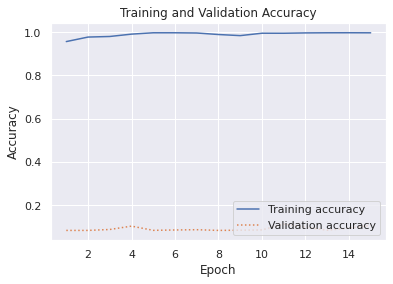

In [ ]:
plotModelHist(hist)

In [ ]:
y_predicted = model.predict(X_test) < 0.5

In [ ]:
printEval(y_test, y_predicted)

Test Accuracy:  0.8894192521877486
Precision micro:  0.8894192521877486
F1 Score micro:  0.8894192521877486
Recall Micro:  0.8894192521877486
Recall Weighted:  0.8894192521877486


#Models


##Resnet50

In [ ]:

def identity_block(X, f, filters, stage, block):
    
    layer_name = 'res' + str(stage) + block + 'br'
    bn_name_base = 'bn' + str(stage) + block + 'br'
    
    F1, F2, F3 = filters
    
    prev_X = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding =
               'valid', name = layer_name + 'identity_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding =
               'same', name = layer_name + 'identity_b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding =
               'valid', name = layer_name + 'identity_c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_c')(X)

    # Add shortcut value to main path
    X = Add()([prev_X, X])
    X = Activation('relu')(X)
        
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
        
    layer_name = 'res' + str(stage) + block + 'br'
    bn_name_base = 'bn' + str(stage) + block + 'br'
    F1, F2, F3 = filters
    prev_X = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = layer_name + 'identity_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding =
               'same', name = layer_name + 'identity_b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding =
               'valid', name = layer_name + 'identity_c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_c')(X)
    prev_X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding =
                        'valid', name = layer_name + '1', kernel_initializer = glorot_uniform(seed=0))(prev_X)
    prev_X = BatchNormalization(axis = 3, name = bn_name_base + '1')(prev_X)
    X = Add()([prev_X, X])
    X = Activation('relu')(X)
   
    return X

In [ ]:
def ResNet50( classes, input_shape):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1, 1))(X_input)
    # X._estimator_type = "classifier"
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(1,1),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',top_5_accuracy])

    return model

##Get Model 1

In [ ]:
def getModel1():
  #simple nn without any dropout rate
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim = 10240))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics = ['acc'])
  return model

##Get Model 2

In [ ]:
def getModel2(input_shape):
  #simple nn with a dropout rate
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim = 10240))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics = ['acc'])
  return model

##Getmodel3

In [ ]:
def getModel3(input_dim):
  #cnn with GRUs, max2d pooling, and batch normalization
    model = Sequential()
    # model._estimator_type = "classifier"
    model.add(Conv2D(20, kernel_size=(1, 3), padding='same', input_shape=(*input_dim, 4)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(20, kernel_size=(1, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(20, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(20, kernel_size=(5, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(20, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(20, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 1)))
    model.add(Conv2D(64, kernel_size=(1, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(64, kernel_size=(5, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(5, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(128, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(256, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(256, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(256, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01), activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    return model

##Getmodel4

In [ ]:
def getModel4(input_dim):
  #CNN with GRU, Dropout, biLSTM, Permute layer
    model = Sequential()
    # model._estimator_type = "classifier"
    model.add(Conv2D(64, kernel_size=(1, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros(), input_shape=(input_dim)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(64, kernel_size=(3, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(3, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Permute((2, 1, 3)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(128, dropout=0.25, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.25, return_sequences=False)))
    model.add(Dense(64))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.0001), activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, decay=1e-6), metrics=['accuracy'])
    model.summary()
    return model

#Output of Models

In [18]:
def plotModelHist(hist):
  #plotting the model's history over the epocs
  print("Model's history Over the Epocs")
  sns.set()
  acc = hist.history['accuracy']
  val = hist.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()
def printConfusionMatrix(model, X_test, y_test):
  # predicting and displaying the confusion matrix
  y_predicted = model.predict(X_test) > 0.5
  print(y_predicted)
  try:
    mat = confusion_matrix(y_test, y_predicted)
  except:
    res = []
    for i in range (len(y_predicted)):
      if y_predicted[i][0] == True:
        res.append(0)
      else:
        res.append(1)
    double = False
    y_predicted = res
    del res
    mat = confusion_matrix(y_test, y_predicted)
  labels = ['Positive', 'Negative']
  
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
              xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
  return y_predicted
def printEval(y_test, y_predicted):
  # to_return = ''
  # return "Test Accuracy: " + str(accuracy_score(y_test, y_predicted)) + "\n" + "F1 Score micro: " + str(f1_score(y_test, y_predicted, average='micro')) + "\n" + "F1 Score weighted: " + str(f1_score(y_test, y_predicted, average='weighted')) + "\n" + "Recall Micro: " + str(recall_score(y_test, y_predicted, average='micro')) + "\n" + "Recall Weighted: " + str(recall_score(y_test, y_predicted, average='weighted')) + "\n"
  # printing the matrices
  from sklearn.metrics import precision_score
  print("Test Accuracy: " , accuracy_score(y_test, y_predicted))
  print("Precision micro: ", precision_score(y_test, y_predicted, average='micro'))
  print("F1 Score micro: ", f1_score(y_test, y_predicted, average='micro'))
  print("Recall Micro: ",recall_score(y_test, y_predicted, average='micro'))
  print("Recall Weighted: ",recall_score(y_test, y_predicted, average='weighted'))


#Applying the model

In [ ]:
def applyModel(X_train, y_train, X_val, y_val):
  model = ResNet50(2, (160, 16, 4))
  hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=5, batch_size=32)
  return hist, model

## **Dumping** The model

In [ ]:
def dumpModel(model):
  path = '/content/drive/My Drive/FYP/Models/'
  pickle.dump(model, open(path + input() + '.sav', 'wb'))
def loadModel(path):
  return pickle.load(open(path, 'rb'))

# dumpModel(model)

#*Implementing the code*

##***Loading Data***

Loading Delta MFCCs

In [ ]:
X_train, X_val, y_train, y_val, X_test, y_test = perform(getMFCCDelta())

Loading MFCCs

In [ ]:
X_train, X_val, y_train, y_val, X_test, y_test = getData("/content/drive/My Drive/FYP/spectral_centroid.txt", 'mfcc')

##Loading Pre-Trained Models

-Model 3 Trained on MFCCs

In [ ]:
model3mfcc =  tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/sequential3-98ACC-500outlier.h5')

-Model 4 Trained on MFCCs

In [ ]:
model4mfcc = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/model_mfcc_96.h5')

-ResNet50 Trained on MFCCs

In [ ]:
resnet50mfcc = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Mfcc/resnet50_Mfcc/my_model', 
                                          custom_objects={'top_5_accuracy':top_5_accuracy})

-Model 3 Trained on Delta MFCCs

In [ ]:
model3delta = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Delta Mfcc/model3DeltaMFCC.h5')

-Model 4 Trained on Delta MFCCs

In [ ]:
model4delta = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Delta Mfcc/model_Deltamfcc_88.h5')

-ResNet50 Trained on Delta MFCCs

In [ ]:
resnet50delta = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/Delta Mfcc/resnet50_deltaMfcc', 
                                           custom_objects={'top_5_accuracy':top_5_accuracy})

##Testing Other Predictions

Coswara Data Set

In [ ]:
RunCoswaraSamples(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)

Virufy-Covid

In [ ]:
RunVirifyCovid(model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta)

Local Hospital Test Data

In [ ]:
RUNCovidSamples()

##Loading Models From Scratch

Model 1

In [ ]:
input_shape = (160, 16, 4)
model = getModel1(input_shape)

Model 2

In [ ]:
input_shape = (160, 16, 4)
model = getModel1(input_shape)

Model 3 

In [ ]:
input_shape = (160, 16)
model = getModel1(input_shape)

Model 4

In [ ]:
input_shape = (160, 16)
model = getModel1(input_shape)

ResNet50

In [ ]:
input_shape = (160, 16, 4)
model = getModel1(input_shape)

##Training the model

Fitting Model to Train the dataset
> Validation Set -> X_validation and y_validation

> Testing Set -> X_test and y_test

> Setting verbose to 1

> Set Epochs to number of epochs (Recommended <->  30)

In [ ]:
validation_data = (X_val, y_val)
epochs = 30
call_backs = []
batch_size = 32
verbose = 1
hist = model.fit(X_train, y_train, epochs = epochs, call_backs = call_backs, verbose = verbose)

Print Model History

In [ ]:
plotModelHist(hist)

##Get Model Prediction


> Prediction for models

In [ ]:
y_pred = model.predict(X_test) > 0.5

>**Get flattened list of single valued prediction**

In [ ]:
y_pred = getPred(y_pred)

> **Get Evaluation of the model**

In [ ]:
printEval(y_test, y_pred)

## Save Model

In [ ]:
model.save('PATH_TO_DIRECTORY/_name_.h5')

#Test Majority Voting

In [ ]:
model3mfcc, model4mfcc, resnet50mfcc, model3delta, model4delta, resnet50delta = LoadAllTrainedModels()

In [ ]:
def Append(mfcc):
    if len(mfcc)>512:
      return mfcc
    while len(mfcc) != 512:
      mfcc.append(0.0)
    return mfcc
def make_append(mfcc):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(Append(mf.tolist()))
    return new_mfcc
X_mfcc = []
X_delta = []
y, sr = librosa.load('/content/drive/My Drive/FYP/Runtime/result.wav')
mfcc = librosa.feature.mfcc(y=y, sr=sr)
mfcc_delta = librosa.feature.delta(mfcc)
X_mfcc.append(make_append(mfcc))
X_delta.append(make_append(mfcc_delta))
X_mfcc = np.asarray(X_mfcc)
X_delta = np.asarray(X_delta)
X_mfcc = preprocessing.scale(preprocessing.normalize(X_mfcc.reshape(-1, 1)))
X_delta = preprocessing.scale(preprocessing.normalize(X_delta.reshape(-1, 1)))
a = getPred(model3mfcc.predict(X_mfcc.reshape(-1, 160, 16, 4))>0.5)
b = getPred(model4mfcc.predict(X_mfcc.reshape(-1, 160, 16, 4))>0.5)
c = getPred(model3delta.predict(X_delta.reshape(-1, 160, 16, 4))>0.5)
d = getPred(model4delta.predict(X_delta.reshape(-1, 160, 16, 4))>0.5)
e = getPred(resnet50mfcc.predict(X_mfcc.reshape(-1, 160, 16, 4))>0.5)
f = getPred(resnet50delta.predict(X_delta.reshape(-1, 160, 16, 4))>0.5)
y = [a[0], b[0], c[0], d[0], e[0], f[0]]
x = Counter(y)
if x.most_common(1)[0][0]:
  print("Covid")
else:
  print("Healthy")

Healthy
